# Binary classification with Naive Bayes  

We will apply the naive Bayes algorithm to a problem of binary classification. The dataset we will use is the well know Titanic from Kaggle. The mathematical formulation of our problem is:  
$$P(Survived \mid X) = \frac{P(X \mid Survived)P(Survived)}{P(X)}$$ 
with $X = (x_1, x_2, ..., x_n)$ is the observation of n variables that we need to classify  

Under the assumption of independance of Naive Bayes, we compute the a posteriori probabilities for the 2 classes *Survived* and *Deceased* and assign the observation $X$ to the class with the highest a posteriori probability:     
$$P(Survived \mid X) = \frac{P(x_1 \mid Survived)...P(x_n \mid Survived)P(Survived)}{P(X)}$$
$$P(Deceased \mid X) = \frac{P(x_1 \mid Deceased)...P(x_n \mid Deceased)P(Deceased)}{P(X)}$$

Our submission will be evaluated on its accuracy:  
$$accuracy = \frac{True Positive + True Negative}{total \ number \ of \ observations}$$
We will take advantage of the low number of predictors in the Titanic dataset to focus on the data engineering phase and create a predictor with highest accuracy. 

In [15]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

#from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette('muted')

from sklearn.naive_bayes import BernoulliNB

# multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data exploration  
The dataset includes 10 explanatory variables:
* 2 continuous numerical variables Age and Fare
* 2 discrete numerical variables SibSp (number of siblings and spouse aboard) and Parch (number pf parents and children aboard)
* 1 categorical ordinal variable Pclass
* 5 categorical nominal variables Name, Sex, Ticket, Fare, Cabin, Embarked  

We can build a very simple estimator by classifying all observations as Deceased. Since 61.6% of all observations did not survive, this estimator has an accuracy of 0.616. This is the baseline to estimate the improvement of our estimator.

In [16]:
# Load datasets
train = pd.read_csv('./input/train.csv', index_col = 'PassengerId')
test = pd.read_csv('./input/test.csv', index_col = 'PassengerId')

# create temporary dataframe for data exploration
explo = train.copy()
n_obs = explo.shape[0]
explo.head()

print('probability of not surviving = {:.4f}'.format(1 - explo.Survived.mean()))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


probability of not surviving = 0.6162


### NA values
For both train and test datasets:
* variable Age is missing values in 20% of observations 
* variable Cabin is missing values in about 80% of observations  
Additionnally, the train dataset contains a few rows with missing value for Embarked, while the test dataset has few rows with missing value for Fare variable.

In [17]:
print('Frequency of NA values in the TRAIN dataset:')
train.isna().sum() / train.shape[0]
print('Frequency of NA values in the TEST dataset:')
test.isna().sum() / test.shape[0]

Frequency of NA values in the TRAIN dataset:


Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Frequency of NA values in the TEST dataset:


Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64

### variable Sex
This variable has a high explanatory power: building an estimator only based on it (all females survived, all males died) increases the accuracy from 0.616 to 0.787.  
Sex will be a major criteria of our classification.

Sex Survived          
             count      mean
0  female      314  0.742038
1    male      577  0.188908

accuracy = 0.7868


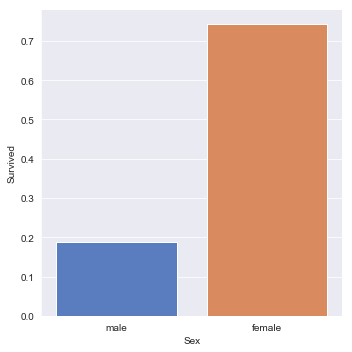

In [18]:
df = explo[['Sex','Survived']].groupby('Sex', as_index=False).agg({'Survived': ['count','mean']})
display(df)
#accuracy = (df.iloc[0,1] * df.iloc[0,2] )
# compute accuracy
true_positive = df.loc[0,('Survived','count')] * df.loc[0,('Survived','mean')]
true_negative = df.loc[1,('Survived','count')] * (1 - df.loc[1,('Survived','mean')])
accuracy = ( true_positive + true_negative) / n_obs
print('accuracy = {:.4f}'.format(accuracy))
        
sns.catplot(x='Sex', y='Survived', data=explo, kind='bar', ci=None);

### variable Age
A plot of a logistic regression of Survival versus Age for male and female shows a slight effect of Age, but with opposite effect:
* for females, probability of survival increases with Age 
* for males, the effect is opposite and probability of survival decreases with Age  

We are leaving for now this variable and will see later how to take it into account.

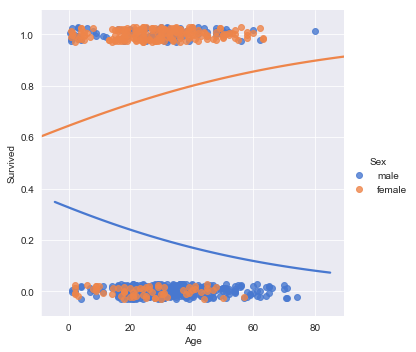

In [19]:
sns.lmplot(x='Age', y='Survived', data=explo, hue='Sex', logistic=True, y_jitter=.03, ci=None);

### variable Name
The variable Name contains a title (such as Mr, ir, Dr, Mrs, ...) for each passager. We extract this title and lloked at survival rate as a function of title. This shows:
* a perfect map from Title to Sex 
* a higher survival rate for title Mrs compared to Miss (ie unmarried women plus female children)
* a lower survival rate for title Mr compared to Master (ie male children)
* Survival probability for title Master is above 0.5, therefore using this variable will help to better classify males  

The variable Title explains the impact of both Sex and Age and will be used instead of these 2 variables.   

Title Survived          
             count      mean
0  Master       40  0.575000
1    Miss      185  0.702703
2      Mr      537  0.160149
3     Mrs      129  0.798450

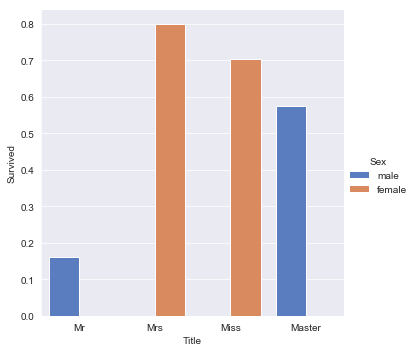

In [20]:
def get_title(data):
    # we do not touch the original dataframe
    df = data.copy()  
      
    # extract title from Name
    df['Title'] = df['Name'].apply(lambda x: 
        x[x.find(',')+2:x.find('.')]) 
    # and regroup values to get a proxy for male/female + child/adult
    df['Title'].replace(['Mr','Don','Rev','Dr','Major','Sir','Col',
      'Capt','Jonkheer'], 'Mr', inplace=True) 
    df['Title'].replace(['Mrs','Mme','Lady','the Countess','Dona'], 
      'Mrs', inplace=True)     
    df['Title'].replace(['Miss','Mlle','Ms'], 'Miss', inplace=True) 
    
    #one observation with title Dr is a woman and should be corrected
    df.loc[(df.Title == 'Mr') & (df.Sex == 'female'), 'Title'] = 'Mrs'
    
    return df
 
# visualization of interactions btw survival and sex/class 
explo = get_title(train)
df = explo[['Title','Survived']].groupby(['Title'], as_index=False).agg({'Survived': ['count','mean']})
display(df)
sns.catplot(x='Title', y='Survived', hue='Sex', data=explo, kind='bar', ci=None);

### variable passenger class Pclass 
The variable Pclass reveals a significant drop of survival rate in 3rd class and will kept as it provides important information.

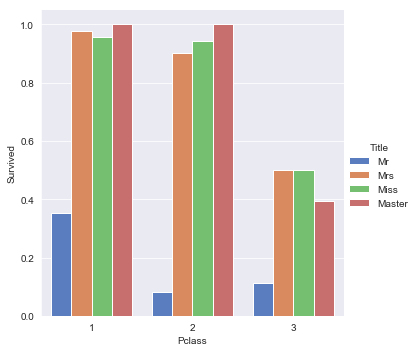

In [21]:
sns.catplot(x='Pclass', y='Survived', hue='Title', data=explo, kind='bar', ci=None);

### variables SibSp and Parch
We compute the size of family groups by summing these 2 variables (plus one). The probability of survival increases with family size up to 4, and is very low for size of 5 or above. Therefore, we will group all sizes of 5 or more in the same category.

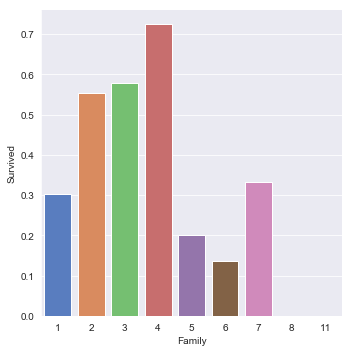

In [22]:
explo['Family'] = explo.SibSp + explo.Parch + 1
sns.catplot(x='Family', y='Survived', data=explo, kind='bar', ci=None);

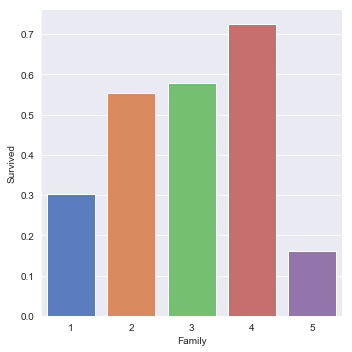

In [23]:
explo['Family'] = explo['Family'].apply(lambda x: x if x < 5 else 5)
sns.catplot(x='Family', y='Survived', data=explo, kind='bar', ci=None);

### variables Ticket, Fare and Cabin
We drop these 3 variables as Fare is likely to be correlated to Pclass, and Cabin has missing values in 80% of cases. Ticket variable might have some predictive power but we igore it for this study.  
Future work might be to confirm correlation between Fare and Pclass, and investigate the 2 other variables Cabin and Ticket.

### variable Embarked
This variable has some impact on the survival rate so we will kep it

In [24]:
df = explo[['Embarked','Survived']].groupby(['Embarked'], as_index=False).agg({'Survived': ['count','mean']})
display(df) 

Embarked Survived          
              count      mean
0        C      168  0.553571
1        Q       77  0.389610
2        S      644  0.336957

## Data Engineering

In [25]:
train = get_title(train)
test = get_title(test)

train['Family'] = train.SibSp + train.Parch + 1
test['Family'] = test.SibSp + test.Parch + 1

# fill missing values for Embarked with most frequent value (S)
train['Embarked'].fillna('S', inplace=True)
# encode categorical variables
#mapping = {'Sex': {'female': 0, 'male': 1}, 'Embarked': {'C': 0, 'S': 1, 'Q': 2}, 'Title': {'Miss': 0, 'Mrs': 1, 'Master': 2, 'Mr': 3}}
mapping = {'Sex': {'female': 0, 'male': 1}}
train.replace(mapping, inplace=True)
test.replace(mapping, inplace=True)
train = pd.get_dummies(train, columns=['Pclass', 'Embarked', 'Title'], drop_first=False)
test = pd.get_dummies(test, columns=['Pclass', 'Embarked', 'Title'], drop_first=False)

# drop non-required columns
train.drop(['Name', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Age','Cabin'], axis=1, inplace=True)
test.drop(['Name', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=True)

## Applying the Naive Bayes estimator

In [26]:
nb = BernoulliNB()

X_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']

nb.fit(X_train, y_train)
nb.score(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

0.8047138047138047

In [27]:
# make submission - result = 0.77511 can do better
y_test = nb.predict(test)
test['Survived'] = y_test

test.to_csv('./output/result.csv', 
                columns=['Survived'],
                header=True,
                index=True)